In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import os
# image_path = os.path.join("data/Lung Segmentation/CXR_png")
# mask_path = os.path.join("data/Lung Segmentation/masks/")

In [2]:
image_path = os.path.join("/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/data/Lung Segmentation/CXR_png/")
mask_path = os.path.join("/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/data/Lung Segmentation/masks/")
aug_img_path = os.path.join("/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/data/Lung Segmentation/aug_img/")
aug_mask_path = os.path.join("/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/data/Lung Segmentation/aug_masks/")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name : ", len(check))

Total mask that has modified name :  566


In [6]:
aug_images = os.listdir(aug_img_path)
aug_mask = os.listdir(aug_mask_path)

In [7]:
aug_files = set(os.listdir(aug_img_path)) & set(os.listdir(aug_mask_path))

In [ ]:
len(aug_files)

344

In [8]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in testing_files:
            im = cv2.resize(cv2.imread(os.path.join(image_path, i)), (X_shape, X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]   
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array, mask_array
    
    if flag == "train":
        for i in training_files:
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]
            im_array.append(im)
            mask_array.append(mask)
            
        return im_array, mask_array
    
    if flag == "aug":
        for i in aug_files:
            im = cv2.resize(cv2.imread(os.path.join(aug_img_path, i)), (X_shape, X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(aug_mask_path,i)),(X_shape,X_shape))[:,:,0]
            im_array.append(im)
            mask_array.append(mask)
            
        return im_array, mask_array

In [9]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0,6,3):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [10]:
dim = 64*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)
X_aug, y_aug = getData(dim,flag="aug")

training set


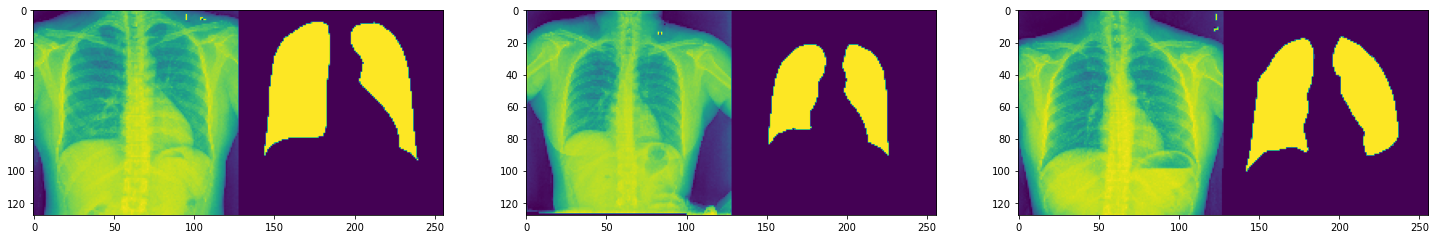

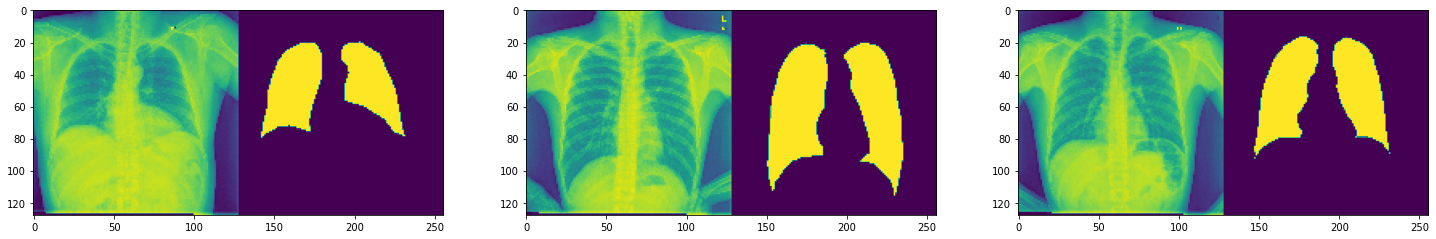

testing set


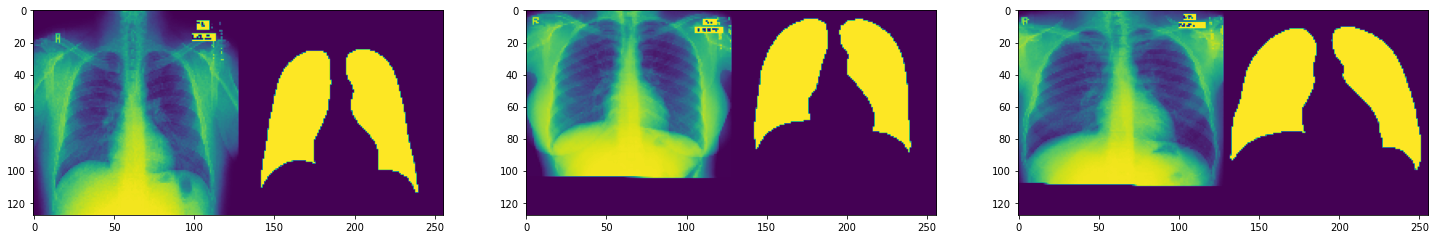

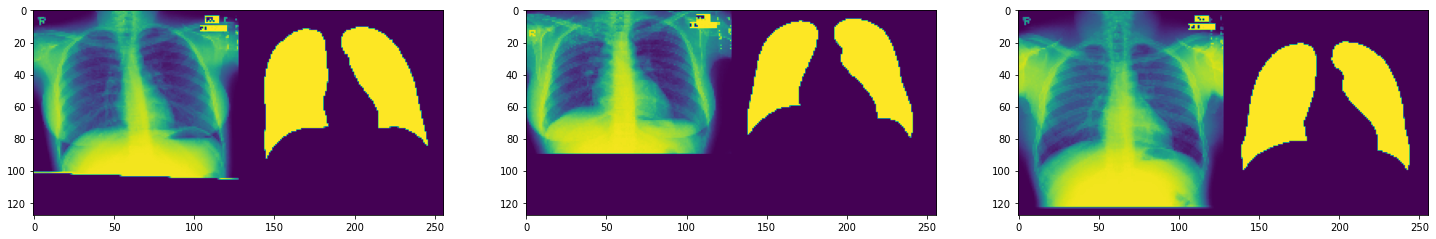

augmentation set


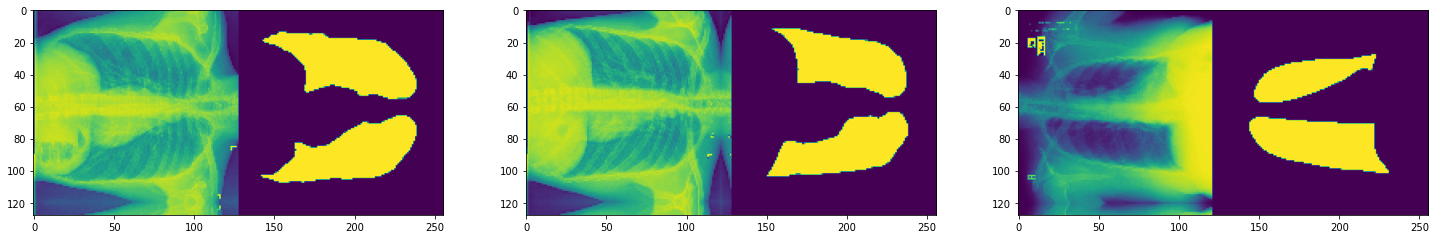

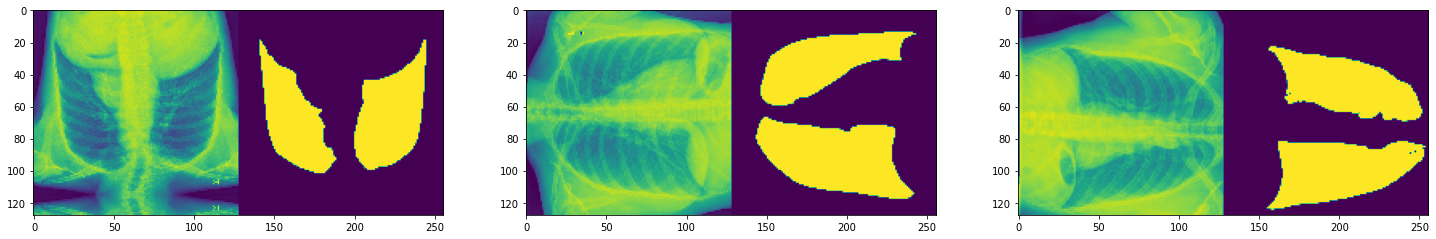

In [11]:
print("training set")
plotMask(X_train, y_train)
print("testing set")
plotMask(X_test, y_test)
print("augmentation set")
plotMask(X_aug, y_aug)

In [12]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
X_aug = np.array(X_aug).reshape(len(X_aug),dim,dim,1)
y_aug = np.array(y_aug).reshape(len(y_aug),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
assert X_aug.shape == y_aug.shape
images = np.concatenate((X_train,X_test,X_aug),axis=0)
mask  = np.concatenate((y_train,y_test,y_aug),axis=0)

In [13]:
images.shape

(1048, 128, 128, 1)

In [14]:
mask.shape

(1048, 128, 128, 1)

In [15]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [16]:
import numpy as np
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Concatenate, AveragePooling2D
from tensorflow.keras.models import Model
import random 
from tensorflow.keras.layers import BatchNormalization



In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def unet6(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = AveragePooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [18]:
model = unet6(input_size = (128,128,1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_coef_loss,
             metrics = [dice_coef, 'binary_accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 64, 64, 8)   0           ['conv2d_1[0][0]']           

In [19]:
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])



loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 10,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

from google.colab import files
model.save('lung_segmentation_10epochs_avg_pooling_700kparam_aug.h5')
files.download('lung_segmentation_10epochs_avg_pooling_700kparam_aug.h5')

clear_output()

In [21]:
from google.colab import files
model.save('lung_segmentation_10epochs_avg_pooling_700kparam_aug.h5')
files.download('lung_segmentation_10epochs_avg_pooling_700kparam_aug.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

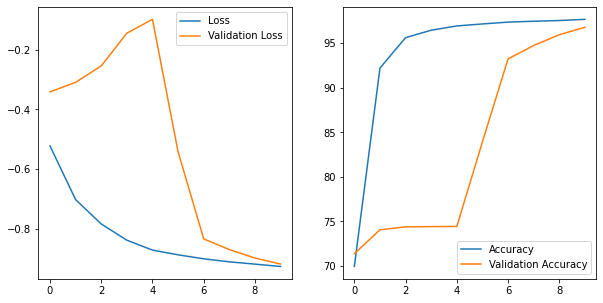

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

plt.savefig('loss_and_accuracy_avg_pooling_700kparam_aug.png');

from google.colab import files
files.download('loss_and_accuracy_avg_pooling_700kparam_aug.png')

In [ ]:
validation_vol.shape

(105, 128, 128, 1)

4/4 [==============================] - 6s 1s/step


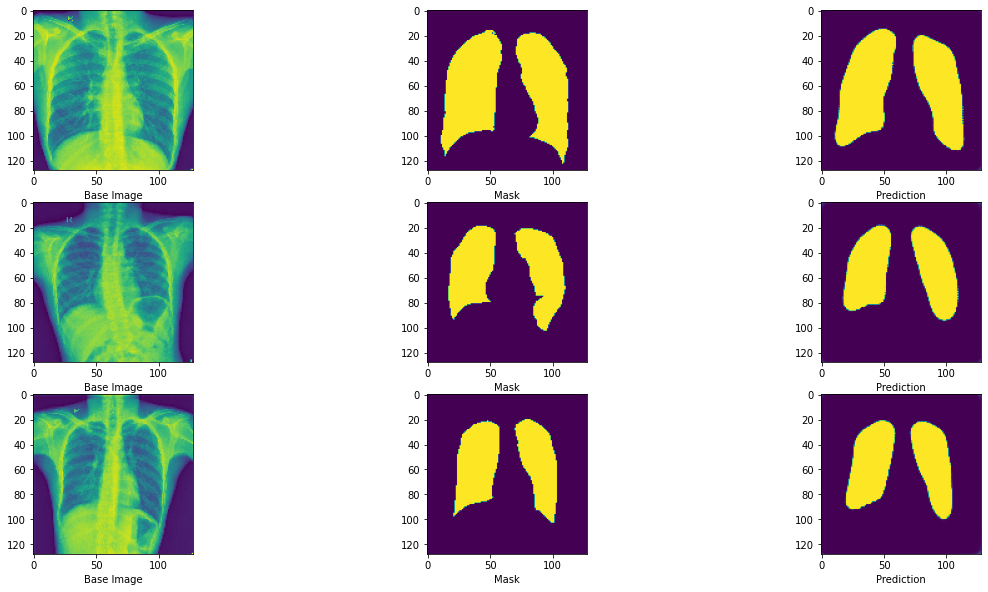

In [ ]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

In [ ]:
from keras.models import load_model

In [ ]:
my_model = load_model('/content/lung_segmentation_80epochs_avg_pooling_700kparam_aug.hdf5'
                      ,custom_objects={'dice_coef_loss': dice_coef_loss,
                                      'dice_coef':dice_coef})


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

my_model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])



loss_history = my_model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 10,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

from google.colab import files
my_model.save('lung_segmentation_20epochs_avg_pooling_700kparam_aug.hdf5')
files.download('lung_segmentation_20epochs_avg_pooling_700kparam_aug.hdf5')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: -0.7763 - dice_coef: 0.7763 - binary_accuracy: 0.9677
Epoch 1: val_loss improved from inf to -0.79537, saving model to cxr_reg_weights.best.hdf5
53/53 [==============================] - 162s 3s/step - loss: -0.7763 - dice_coef: 0.7763 - binary_accuracy: 0.9677 - val_loss: -0.7954 - val_dice_coef: 0.7952 - val_binary_accuracy: 0.9562 - lr: 2.0000e-04
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: -0.7928 - dice_coef: 0.7928 - binary_accuracy: 0.9709
Epoch 2: val_loss improved from -0.79537 to -0.81247, saving model to cxr_reg_weights.best.hdf5
53/53 [==============================] - 143s 3s/step - loss: -0.7928 - dice_coef: 0.7928 - binary_accuracy: 0.9709 - val_loss: -0.8125 - val_dice_coef: 0.8123 - val_binary_accuracy: 0.9616 - lr: 2.0000e-04
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: -0.8076 - dice_coef: 0.8076 - binary_accuracy: 0.9729
Epoch 3: val_loss improved from -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

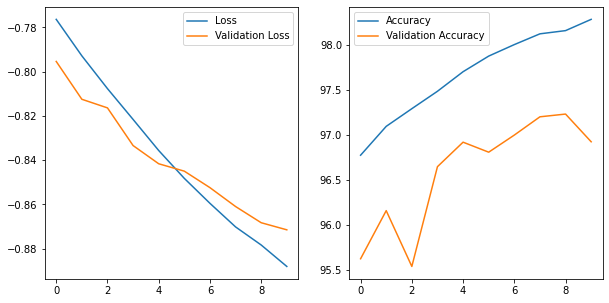

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

plt.savefig('loss_and_accuracy_avg_pooling_700kparam_aug_20epochs.png');

from google.colab import files
files.download('loss_and_accuracy_avg_pooling_700kparam_aug_20epochs.png')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [ ]:
test_x = sorted(glob("/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/data/Lung Segmentation/CXR_png/*"))
test_y = sorted(glob("/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/data/Lung Segmentation/masks/*"))

In [ ]:
len(validation_vol)

In [ ]:
y_pred=my_model.predict(validation_vol)

4/4 [==============================] - 5s 943ms/step


In [ ]:
len(y_pred)

71

In [ ]:
y.shape

(16384,)

In [ ]:
SCORE = []

y_pred=my_model.predict(validation_vol)

for i in range(len(validation_vol)):
  y=validation_seg[i]
  y_pred_i=y_pred[i]

  y_pred_i = y_pred_i.astype(np.int32)
  y = y.astype(np.int32)

  """ Flattening the numpy arrays. """
  y = y.flatten()
  y_pred_i = y_pred_i.flatten()


  """ Calculating metrics values """
  acc_value = accuracy_score(y, y_pred_i)
  f1_value = f1_score(y, y_pred_i, labels=[0, 1], average="binary")
  jac_value = jaccard_score(y, y_pred_i, labels=[0, 1], average="binary")
  recall_value = recall_score(y, y_pred_i, labels=[0, 1], average="binary")
  precision_value = precision_score(y, y_pred_i, labels=[0, 1], average="binary")
  SCORE.append([i, acc_value, f1_value, jac_value, recall_value, precision_value])

4/4 [==============================] - 3s 735ms/step


In [ ]:
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

Accuracy: 0.96789
F1: 0.92902
Jaccard: 0.86881
Recall: 0.87916
Precision: 0.98686


In [ ]:
df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("score_avg_pooling.csv")

In [ ]:
from google.colab import files
files.download('score_avg_pooling.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>